In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/back-pack-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/back-pack-data/train.csv
/kaggle/input/back-pack-data/test.csv
/kaggle/input/back-pack-data/training_extra.csv


## BackPack Price Prediction using LightGBM and XGBOOST

**In this project i will be try to predict the price of the back pack** , I will be try my best to explain each steps which i followed and to get the good predictions,In this Notebook i will be using some visualisations to understand the data and **VotingRegressor** to get the best combined model predictions


**About Dataset / Input:**

**train data** : traing data

**test data**  testing data / eval data

**extra_train_data** : extra train data for model training

**Expected Output :**
prediction of the back pack with Id and predicted price

**Import the basic libs**

- i will be using seaborn for some visaualisations

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**import the triain and test datasets and concat the extra data set for the better model training**

In [46]:
train_data = pd.read_csv('/kaggle/input/back-pack-data/train.csv')
test_data = pd.read_csv('/kaggle/input/back-pack-data/test.csv')
extra_train_data = pd.read_csv('/kaggle/input/back-pack-data/training_extra.csv')

#lets concat the extra train data to main train data
train_data = pd.concat([train_data,extra_train_data])

## **Exploratory data analysis**


In [47]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [48]:
test_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [49]:
#check the shape of the train data 
train_data.shape

(3994318, 11)

In [50]:
#lets see the data types and not-null information about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


**observation**
    we have mixture of categorical and number type objects 

In [51]:
#lets check for the missing values in the data
train_data.isnull().sum()

id                           0
Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

**observation:**
we have missing data, we will try to fill them further in the code
- we can fill them either mean, median, or mode, it totaly depends on the algorithm
- algorithm sensistive to the outliers we will try fill with median and  its best practice
- for categorical data we will fill with the mode

In [52]:
#lets see about the value counts in each of categorical data
for i in train_data.select_dtypes('object'):
    print(train_data[i].value_counts())
    print('*'*100)

Brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
Name: count, dtype: int64
****************************************************************************************************
Material
Polyester    1060882
Leather       976186
Nylon         942656
Canvas        903632
Name: count, dtype: int64
****************************************************************************************************
Size
Medium    1354487
Large     1312295
Small     1239751
Name: count, dtype: int64
****************************************************************************************************
Laptop Compartment
Yes    1972937
No     1922848
Name: count, dtype: int64
****************************************************************************************************
Waterproof
Yes    1969205
No     1930789
Name: count, dtype: int64
****************************************************************************************************
St

## **Data visualisation**

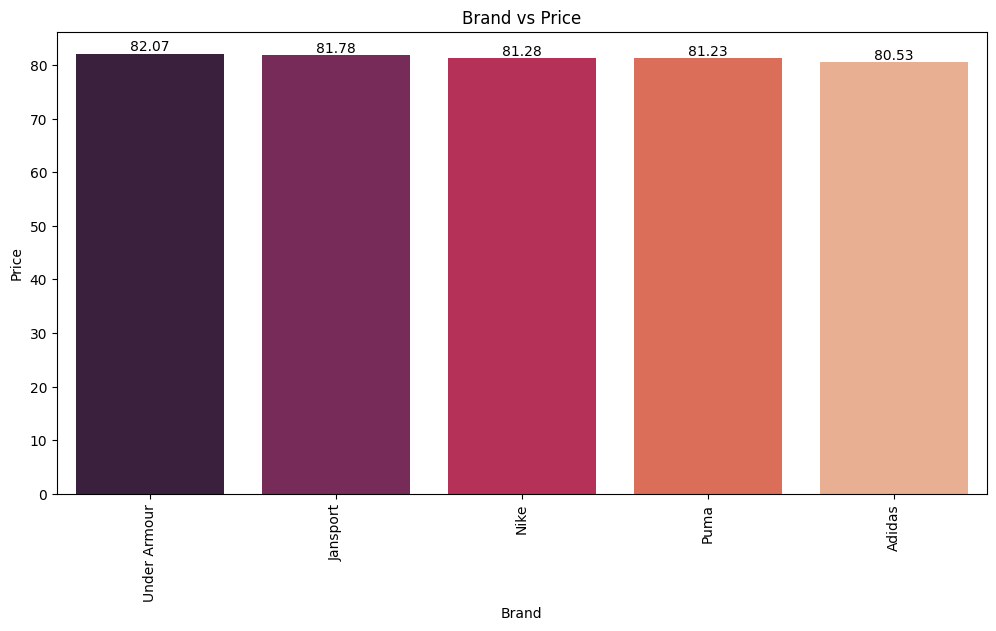

In [53]:
#will see the brand vs price as brand plays some roles in pricing

plt.figure(figsize=(12,6))
x_values = train_data.groupby('Brand')['Price'].mean().sort_values(ascending=False).index
y_values = train_data.groupby('Brand')['Price'].mean().sort_values(ascending=False).values
ax = sns.barplot(x=x_values,y=y_values,palette='rocket')
plt.title('Brand vs Price')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
# Iterate over the bars and display actual values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")  # Format as needed

plt.show()

**observation**
- all the brands avg price range seems to be equal
- no brand has significantly higher price range
- adidas seems to have less avg price compared to others 

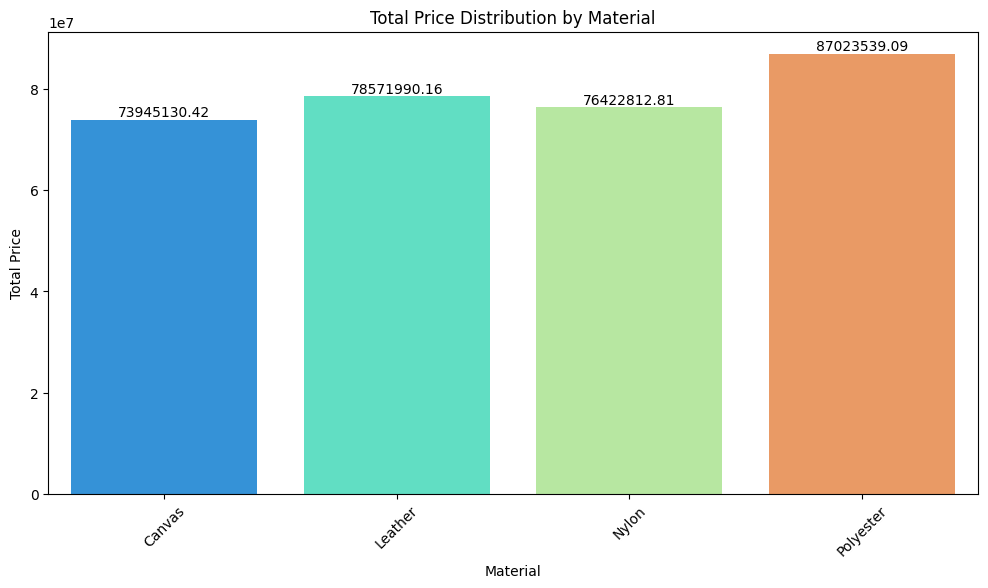

In [54]:

plt.figure(figsize=(12,6))

material_sums = train_data.groupby('Material')['Price'].sum().reset_index()

# Create a bar plot with actual values
ax = sns.barplot(x='Material', y='Price', data=material_sums, palette='rainbow')

plt.title('Total Price Distribution by Material')
plt.xlabel('Material')
plt.ylabel('Total Price')

# Iterate over the bars and display actual values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")  # Format as needed

plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()


**observation**
- polyester material bags seems to have greater demand and canvas holds less

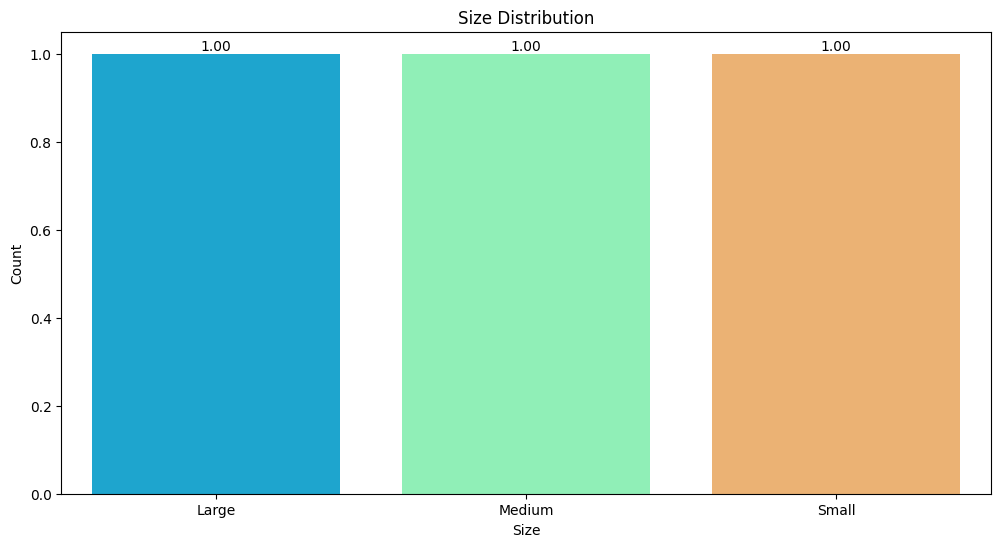

In [55]:
#distribution based on the size of the bags

plt.figure(figsize=(12,6))
ax = sns.countplot(x=train_data.groupby('Size').count().index,palette='rainbow')
plt.title('Size Distribution')
plt.xlabel('Size')
plt.ylabel('Count')
# Iterate over the bars and display actual values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")  # Format as needed

plt.show()

**observation**
- equal distribution of size

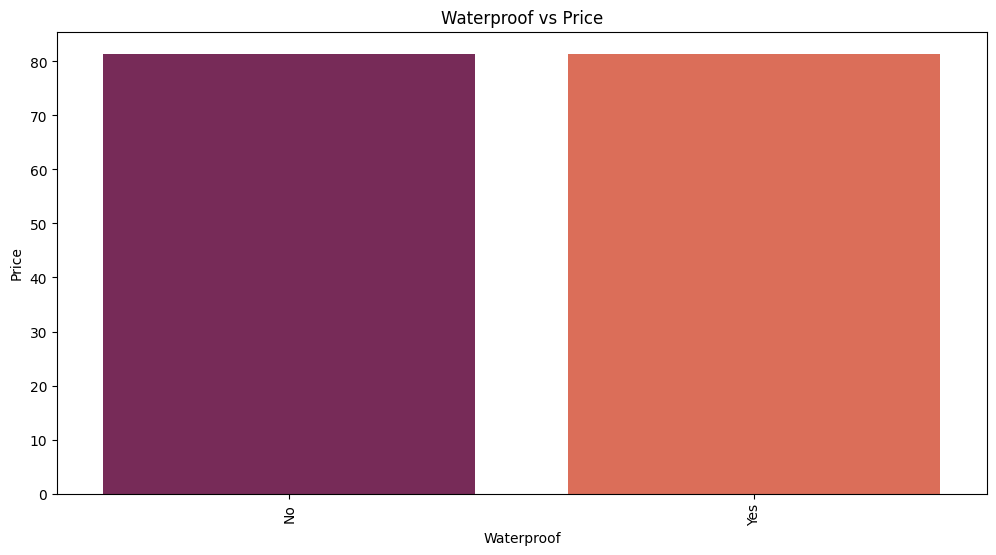

In [56]:
#lets see the how the Waterproof will impact the price
plt.figure(figsize=(12,6))
x_values = train_data.groupby('Waterproof')['Price'].mean().sort_values(ascending=False).index
y_values = train_data.groupby('Waterproof')['Price'].mean().sort_values(ascending=False).values
sns.barplot(x=x_values,y=y_values,palette='rocket')
plt.title('Waterproof vs Price')
plt.xlabel('Waterproof')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


**observation**
- Either waterproof or no the price mean is not significantly different

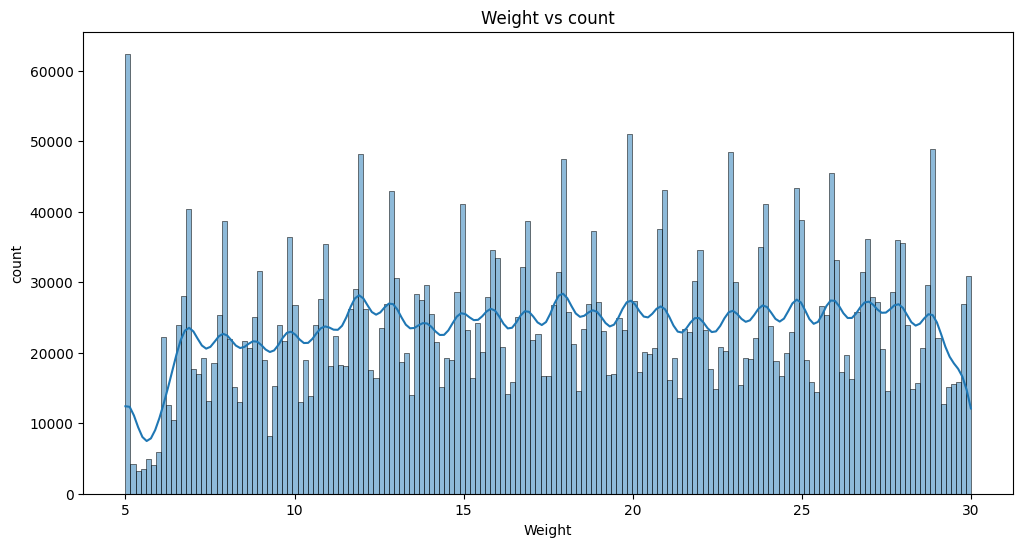

In [57]:
#now lets undersatnd how the weight will play the role in price

plt.figure(figsize=(12,6))
sns.histplot(train_data['Weight Capacity (kg)'],kde=True)
plt.title('Weight vs count')
plt.xlabel('Weight')
plt.ylabel('count')
plt.show()


**observation**
- bag's around 5kg is most common in the dataset, people prefer the bags which are around 5kg
- however we see no data below 5, so the customer not tend to prefer bags below 5kg and 30kg 

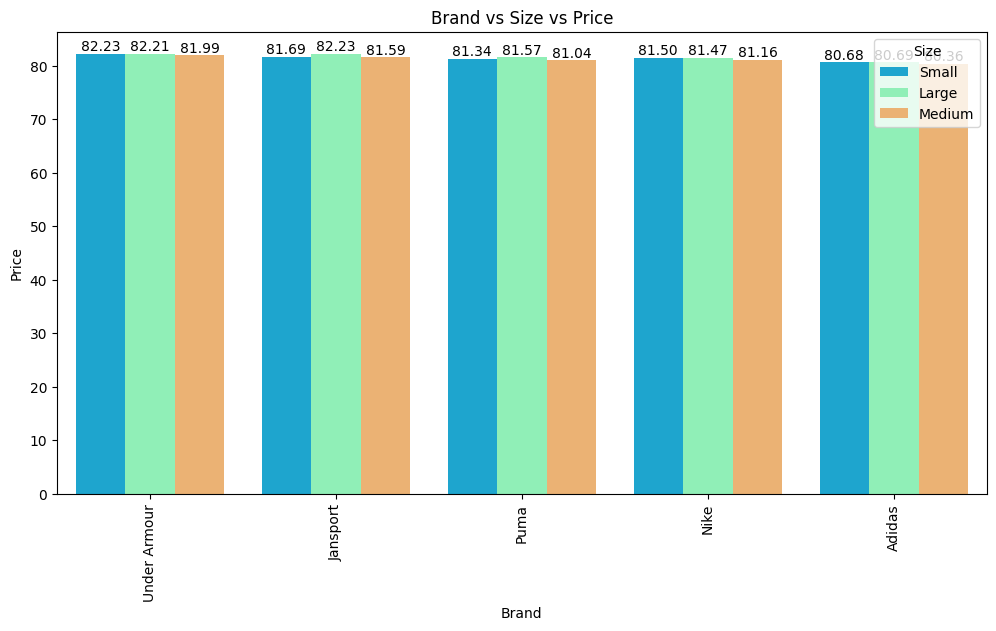

In [58]:
#lets see the avg price for all the brand's based on the size

brand_size_price = train_data.groupby(['Brand','Size'])['Price'].mean().sort_values(ascending=False)
brand_size_price
plt.figure(figsize=(12,6))
brand_size_price = brand_size_price.reset_index()
ax = sns.barplot(x ='Brand' ,y='Price',hue='Size',data=brand_size_price,palette='rainbow')
plt.title('Brand vs Size vs Price')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
# Iterate over the bars and display actual values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")  # Format as needed

plt.show()

**observation**
- avg price seems same for all the brands it does not matter which size it is.

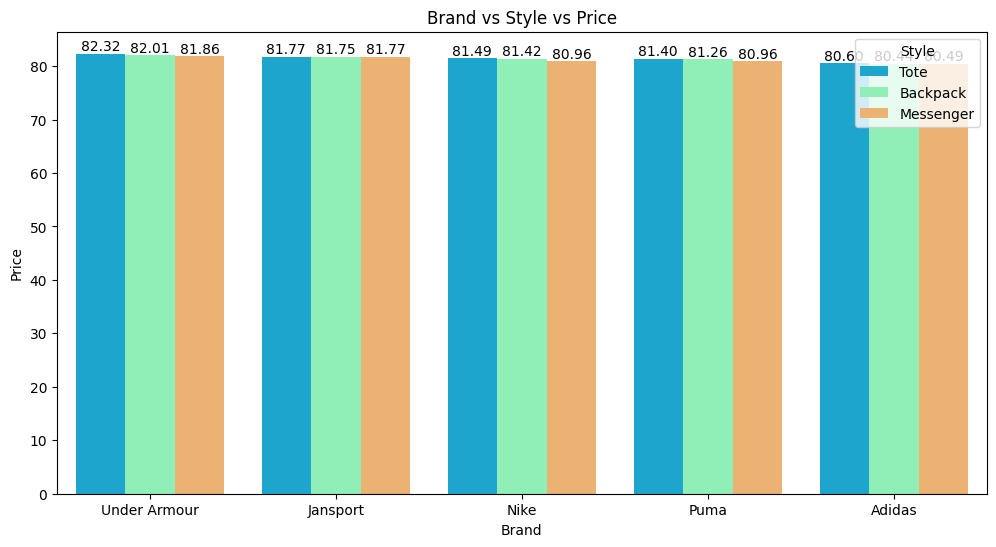

In [59]:
#brand and style and price
brand_style_price = train_data.groupby(['Brand','Style'])['Price'].mean().sort_values(ascending=False)
brand_style_price = brand_style_price.reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(x ='Brand' ,y='Price',hue='Style',data=brand_style_price,palette='rainbow')
plt.title('Brand vs Style vs Price')
plt.xlabel('Brand')
# Iterate over the bars and display actual values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")  # Format as needed

plt.show()

**observation**
- avg price seems same for all the brands it does not matter which style it is.

## **Pre-processing**

**steps to follow for the pre-processing**
- remove the id
- remove the target feature in our case that is price
- find out the categorical features and numrical features
- for numerical we can impute the missing values with median,then scale them for standardisation
- categorical data has to be Label encoded, train and test data should follow the same encoding

**Libs used for the pre-processing task**
- **Pipeline (from sklearn.pipeline)**

  - Creates a sequential workflow of data transformation steps.
  - Ensures transformations are applied in the right order before feeding data into a   model.

- **ColumnTransformer (from sklearn.compose)**

    - Applies different transformations to specific columns (e.g., numerical vs. categorical).
    - Helps process mixed-type data (e.g., scaling numeric features & encoding categorical ones).

- **StandardScaler (from sklearn.preprocessing)**

    - Normalizes numerical features by scaling them to zero mean & unit variance.
    - Ensures features have equal weight in ML models.

- **OneHotEncoder (from sklearn.preprocessing)**

    - Converts categorical variables into a binary matrix (one-hot encoding).
    - Handles categorical data for ML models that require numeric input.
      
- **SimpleImputer (from sklearn.impute)**

    - Fills missing values using strategies like "mean", "median", or "most_frequent".
    - Ensures missing data doesn’t break ML algorithms.


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#saving the Id for the submission
idtest = test_data['id']

'''
drop the id column from the data
'''
train_data.drop(columns=['id'],inplace=True)
test_data.drop(columns=['id'],inplace=True)

# Assume train_data is the training dataset, and test_data is the test dataset
X = train_data.drop(columns=['Price'])  # Features
y = train_data['Price']  # Target variable

# Identify categorical and numerical columns
categorical = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define transformation pipeline for numerical features (imputation + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardization
])

# Define transformation pipeline for categorical features (encoding)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-Hot Encoding with unknown category handling
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ]
)

# Fit-transform on training data
X_processed = preprocessor.fit_transform(X)

# Apply the same transformation to test data
X_test_processed = preprocessor.transform(test_data)

# Convert the processed data back to DataFrames
# Get feature names after transformation
numerical_features = numerical
categorical_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical)

# Combine all feature names
all_features = np.concatenate([numerical_features, categorical_features])

# Create DataFrames
X_processed_df = pd.DataFrame(X_processed, columns=all_features)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_features)



In [61]:
#lets see how the data looks like now
X_processed_df.head()

,Compartments,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Brand_nan,Material_Canvas,Material_Leather,...,Style_Messenger,Style_Tote,Style_nan,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_nan
0,0.541043,-0.917722,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.578013,1.300573,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.187242,-0.196013,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.886700,-0.727615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.532898,-0.037447,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
X_test_processed_df.head()

,Compartments,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Brand_nan,Material_Canvas,Material_Leather,...,Style_Messenger,Style_Tote,Style_nan,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_nan
0,-1.187242,0.381607,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.541043,-0.637706,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.232357,-0.889313,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.532898,0.066921,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.187242,-1.162081,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observation**
- data seems perfect for the model training
- In pre-processing we need to be careful about the possibe data leakage

## **Steps to Prevent Data Leakage** 
- Always fit transformations (imputation, scaling, encoding) on training data only and apply them to test data.
-  Never use target variable information in preprocessing (e.g., mean encoding without K-fold validation).
- Use Pipelines (sklearn.pipeline.Pipeline) to ensure preprocessing is done correctly inside cross-validation.

## **Model Training**

**Some topics to undersatnd before we train model**

**Hyperparameter tuing to select the best model parameters**

**RandomSearchCv**
- Evaluates multiple hyperparameter combinations and selects the best one based on cross-validation scores.
- Finds good hyperparameters without exhaustive search
- resource extensive needs GPU enabled machine if more models and more granular tuning
- better than GridSearch(tests fewer parameter combinations)

**VotingRegressor**
- Combines multiple regression models to improve predictions.
- Averages predictions from different models to reduce variance and improve robustness.
- When you want to combine multiple models (e.g., XGBoost, Random Forest, Linear Regression) for better performance.

In [63]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm  as lgb
from catboost import CatBoostRegressor

from sklearn.ensemble import VotingRegressor

Xtrain,Xtest,ytrain,ytest = train_test_split(X_processed_df,y,test_size=0.2,random_state=42)

In [64]:

# Define individual models with best possible hyperparameters
lgb_model = lgb.LGBMRegressor(
    subsample=0.7,
    num_leaves=30,  
    n_estimators=300,
    max_depth=6,  
    learning_rate=0.01,
    feature_fraction=0.8,  # Randomly selects 80% features per tree
    bagging_freq=5,  # Enables bagging
    reg_lambda=2  # L2 regularization to prevent overfitting
)

xgb_model = xgb.XGBRegressor(
    subsample=0.7,
    n_estimators=300,
    max_depth=5,  
    learning_rate=0.01,
    colsample_bytree=0.8,
    gamma=1.5,  # Adds pruning to avoid overfitting
    reg_lambda=2,  # L2 regularization
    reg_alpha=2,  # L1 regularization
    objective='reg:squarederror',
    random_state=42
)

**Note-** these might not be the optimal hyperparameters, as tuning is resouce extensive i have  trained model with some standard hyper parameter values and used voting regressor to improve the model prediction's

In [65]:
# Fit models individually with early stopping
lgb_model.fit(Xtrain, ytrain, eval_set=[(Xtest, ytest)], eval_metric='rmse', callbacks=[lgb.early_stopping(50)])
xgb_model.fit(Xtrain, ytrain, eval_set=[(Xtest, ytest)], eval_metric='rmse', early_stopping_rounds=50, verbose=False)

# Create Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model)
])

# Train Voting Regressor
voting_regressor.fit(Xtrain, ytrain)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 3195454, number of used features: 34
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value:

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(bagging_freq=5, feature_fraction=0.8,
                                           learning_rate=0.01, max_depth=6,
                                           n_estimators=300, num_leaves=30,
                                           reg_lambda=2, subsample=0.7)),
                            ('xgboost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=N...
                                          gamma=1.5, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.01, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))])

## model predictions 

In [66]:
# Predict on validation set
val_predictions = voting_regressor.predict(Xtest)

# Calculate RMSE on the validation set
rmse = np.sqrt(mean_squared_error(ytest, val_predictions))
print(f"Voting Regressor RMSE: {rmse:.5f}")

# Make predictions on test data
test_predictions = voting_regressor.predict(X_test_processed_df)

# Prepare submission file
submission = pd.DataFrame({'id': idtest, 'Price': test_predictions})
submission.to_csv("submission.csv", index=False)

# Display first few rows
print(submission.head())

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Voting Regressor RMSE: 38.86836
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
       id      Price
0  300000  81.576197
1  300001  82.766334
2  300002  82.196524
3  300003  81.380882
4  300004  79.168240


## **Results**
- all predicted results will be stored in the submission.csv file
  

## Reference 
[xgboost_documenation](https://xgboost.readthedocs.io/en/stable/parameter.html)
[LightGbm_documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html)
[voting_regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)

please upvote the work if you find this intresting! feel free to connect if feel we can have any correction.

uday kumar swamy[uswamy@hawk.iit.edu]